<a href="https://colab.research.google.com/github/ArthurNazarenko/nebius_academy_practice/blob/main/topic2/2.3_intro_to_llm_reasoning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LLM Engineering Essentials by Nebius Academy

Course github: [link](https://github.com/Nebius-Academy/LLM-Engineering-Essentials/tree/main)

The course is in development now, with more materials coming soon. [Subscribe to stay updated](https://academy.nebius.com/llm-engineering-essentials/update/)

# 2.3. Intro to LLM Reasoning

LLMs' reasoning ability has long fascinated people, drawing attention for its practical implications and sparking intriguing theoretical questions. In this series of notebooks, we'll explore what reasoning brings to the table, how our understanding of it has evolved over time, and why it's been generating so much hype lately.

The plan is:

* **R1. Intro to LLM Reasoning**. What LLM reasoning is, for which tasks it is useful (and for which it is not). Have LLMs really learnt to "think" like humans (not exactly).
* **R2. Inference-time compute**. How to make an LLM smarter with orchestration.
* **R3. Establishing non-linear reasoning capabilities**: how DeepSeek R1 was trained and some other approaches.

## Getting ready

In [1]:
!pip install -q openai
!pip install -q datasets --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 7.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-nvrtc-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-runtime-cu12==12.4.127; platform_system == "Linux" and platform_ma

In [4]:
import os

from google.colab import userdata
nebius_api_key = userdata.get('nebius_api_key')

os.environ["NEBIUS_API_KEY"] = nebius_api_key

We'll be calling APIs quite often in this notebook, so let's define a shortcut fuction to avoid repeating all the code. Also, we'll prettify the output in such a way that it can be viewed without scrolling right.

In [5]:
from openai import OpenAI

# Nebius uses the same OpenAI() class, but with additional details
nebius_client = OpenAI(
    base_url="https://api.studio.nebius.ai/v1/",
    api_key=os.environ.get("NEBIUS_API_KEY"),
)

llama_8b_model = "meta-llama/Meta-Llama-3.1-8B-Instruct"

def prettify_string(text, max_line_length=80):
    """Prints a string with line breaks at spaces to prevent horizontal scrolling.

    Args:
        text: The string to print.
        max_line_length: The maximum length of each line.
    """

    output_lines = []
    lines = text.split("\n")
    for line in lines:
        current_line = ""
        words = line.split()
        for word in words:
            if len(current_line) + len(word) + 1 <= max_line_length:
                current_line += word + " "
            else:
                output_lines.append(current_line.strip())
                current_line = word + " "
        output_lines.append(current_line.strip())  # Append the last line
    return "\n".join(output_lines)

def answer_with_llm(prompt: str,
                    system_prompt="You are a helpful assistant",
                    max_tokens=512,
                    client=nebius_client,
                    model=llama_8b_model,
                    prettify=True,
                    temperature=0.6) -> str:

    messages = []

    if system_prompt:
        messages.append(
            {
                "role": "system",
                "content": system_prompt
            }
        )

    messages.append(
        {
            "role": "user",
            "content": prompt
        }
    )

    completion = client.chat.completions.create(
        model=model,
        messages=messages,
        max_tokens=max_tokens,
        temperature=temperature
    )

    if prettify:
        return prettify_string(completion.choices[0].message.content)
    else:
        return completion.choices[0].message.content

# What is LLM Reasoning

There are several ways in which LLMs may respond to your queries.

Sometimes, they just give a direct answer.

In [6]:
result = answer_with_llm("""Who is the main character of the Mistborn trilogy?""",
                         model="meta-llama/Meta-Llama-3.1-405B-Instruct")
print(result)

The main character of the Mistborn trilogy is Vin, a young street urchin who
discovers she has Allomantic abilities. Throughout the series, Vin evolves from
a timid and isolated individual to a confident and powerful figure who plays a
key role in the fight against the Lord Ruler and the forces of darkness.


However, if you give a math task to one of today's LLMs, you'll notice that it doesn't just spit out an answer - it provides a full solution instead

In [7]:
result = answer_with_llm("""In the fantasy world of Xu, they have unique math system:
- "a + b" means min(a,b)
- "a*b" means a + b
Solve the equation x*x + 2*x + 1 = 0""",
                         model="meta-llama/Meta-Llama-3.1-405B-Instruct")
print(result)

To solve the equation, we need to translate it into our familiar math system.
Based on the Xu math system:

- "x*x" means x + x, which is 2x
- "2*x" means 2 + x
- "x*x + 2*x" means min(2x, 2 + x)

Now, let's rewrite the equation:

min(2x, 2 + x) + 1 = 0

Since the minimum value of min(2x, 2 + x) is added to 1, and the result is 0,
we can set up the following equation:

min(2x, 2 + x) = -1

For the minimum value to be -1, both 2x and 2 + x must be greater than or equal
to -1.

From 2x ≥ -1, we get x ≥ -1/2.

From 2 + x ≥ -1, we get x ≥ -3.

However, since the minimum value is -1, one of the expressions must be equal to
-1. Let's consider both cases:

1. 2x = -1 --> x = -1/2
2. 2 + x = -1 --> x = -3

Now, we need to verify which solution satisfies the original equation.

If x = -1/2, then min(2x, 2 + x) = min(-1, 3/2) = -1, and -1 + 1 = 0. This
solution satisfies the equation.

If x = -3, then min(2x, 2 + x) = min(-6, -1) = -6, and -6 + 1 ≠ 0. This
solution does not satisfy the equation.

**Note**. If you're interested in math, Xu's math system is actually called [Tropical Geometry](https://en.wikipedia.org/wiki/Tropical_geometry).

Back in 2023, LLM researchers and users noticed that, at least for mathematical tasks, LLMs produced more accurate answers when generating a full solution rather than simply providing a direct answer. At that time, LLMs didn't always automatically write solutions, and you might have needed to prompt them with `"Take a deep breath and solve this problem step by step."`

Getting detailed, step-by-step solutions was an exciting development. Such solutions became known as **Chains of Thought (CoT)**, and wide discussion began about **LLM reasoning capabilities**.

Today math reasoning is a standard out-of-the box capability of the absolute majority of LLMs. But now, a more powerful paradigm is gaining popularity: **non-linear reasoning**.

### Non-linear reasoning

Soon after Chains of Thoughts (CoT) emerged, it became clear that they are not enough. Indeed, the CoT paradigm assumes that an LLM is able to generate the correct solution from the first attempt, while the human way of thinking involves checking several ideas, experimenting, self-criticizing, and backtracking before generating the final solution

So, the **non-linear reasoning** approach was born.

For a couple of years, non-linear reasoning was established with help of orchestration. Mechanisms such as [Tree of Thoughts](https://arxiv.org/pdf/2305.10601) or [Graph of Thoughts](https://arxiv.org/pdf/2308.09687) were suggested for solving complex problems. We'll discuss them in detail in the **Inference-time compute** notebook.

<center>
<img src="https://drive.google.com/uc?export=view&id=1WZWjI7aY3Vu0zEsAO8u7R73iwsC6KJeq" width=600 />

[Source](https://arxiv.org/pdf/2308.09687)
</center>

A general idea of such approaches is to generate a solution step by step (one prompt = one logical step, unlike CoT), while exploring several reasoning paths and somehow scoring individual steps or whole branches to eventually select the optimal reasoning path.

However, as often happens in Machine Learning, orchestration strategies eventually give way to end-to-end ones. And it seems that we're almost at the point where LLMs are able to perform non-linear reasoning on their own.

To illustrate this, let's compare outputs of Phi-4, Llama, and DeepSeek R1, which is a top-trend non-linear reasoning model.

**The task is:** Imagine that my binary classifier got recall 0.8 on a dataset with balanced classes (same number of class 0 and class 1 objects). What could be its minimal and maximal precision?

<details>
    <summary> Click to see the solution </summary>

Let $x$ be the number of class 1 objects. Than recall 0.8 means that 80% of them are classified as class 1 (that's TN) and 20% as class 0 (that's FN). Let's populate the magic table:

|                | Classified as class 1 | Classified as class 0 |
| :---------------- | :------: | ----: |
| Class 1        |   $0.8x$   | $0.2x$ |
| Class 0           |   ???   | ??? |

Since the dataset is balanced, Class 0 also contains $x$ elements. So, we get some

|                | Classified as class 1 | Classified as class 0 |
| :---------------- | :------: | ----: |
| Class 1        |   $0.8x$   | $0.2x$ |
| Class 0           |   $\alpha x$   | $(1 - \alpha)x$ |

where $0\leqslant \alpha \leqslant 1$ (and that's all we know about $\alpha$. Now, the precision is
$$\frac{0.8x}{0.8x + \alpha x} = \frac{0.8}{0.8 + \alpha},\quad 0\leqslant\alpha\leqslant1$$

Now, some math establishes the answer:
$$0\leqslant\alpha\leqslant1 \Rightarrow 0.8\leqslant 0.8 + \alpha\leqslant 1.8 \Rightarrow$$

$$\Rightarrow\frac1{1.8}\leqslant\frac1{0.8 + \alpha} \leqslant \frac1{0.8}
\Rightarrow \frac49=\frac{0.8}{1.8}\leqslant\frac{0.8}{0.8 + \alpha} \leqslant \frac{0.8}{0.8} = 1$$
</details>

In [ ]:
result = answer_with_llm("""Imagine that my binary classifier got recall 0.8 on a dataset with balanced classes (same number of class 0 and class 1 objects).
What could be its minimal and maximal precision?""",
                model="microsoft/phi-4",
                system_prompt=None,
                max_tokens=4096)
print(result)

To determine the minimal and maximal precision of your binary classifier given
a recall of 0.8 and balanced classes, let's break down what these metrics mean:

- **Recall (Sensitivity or True Positive Rate)** is defined as \( \text{Recall}
= \frac{\text{TP}}{\text{TP} + \text{FN}} \). Here, you are given that recall
is 0.8. This means 80% of the actual positives (class 1) are correctly
identified by the classifier.

- **Precision (Positive Predictive Value)** is defined as \( \text{Precision} =
\frac{\text{TP}}{\text{TP} + \text{FP}} \).

Given that the classes are balanced, let's denote:
- \( N \) as the total number of samples (half of which are class 1 and half
are class 0, so each class has \( \frac{N}{2} \) samples).
- \( \text{TP} \) as the number of true positives.
- \( \text{FN} \) as the number of false negatives.
- \( \text{FP} \) as the number of false positives.

From the recall formula:
\[ \text{Recall} = \frac{\text{TP}}{\text{TP} + \text{FN}} = 0.8 \]

Since the classes 

In [ ]:
result = answer_with_llm("""Imagine that my binary classifier got recall 0.8 on a dataset with balanced classes (same number of class 0 and class 1 objects).
What could be its minimal and maximal precision?""",
                model="meta-llama/Meta-Llama-3.1-70B-Instruct",
                system_prompt=None,
                max_tokens=4096)
print(result)

Given that your binary classifier has a recall of 0.8 on a dataset with
balanced classes, we can analyze the possible range of precision values.

Recall (also known as sensitivity or true positive rate) is defined as:

Recall = TP / (TP + FN)

where TP is the number of true positives (correctly classified class 1 objects)
and FN is the number of false negatives (missed class 1 objects).

Since the recall is 0.8, this means that the classifier correctly classified
80% of the class 1 objects.

Now, let's consider the precision, which is defined as:

Precision = TP / (TP + FP)

where FP is the number of false positives (misclassified class 0 objects).

To find the minimal and maximal precision, we need to consider the possible
values of FP.

**Minimal Precision:**

The minimal precision occurs when the classifier misclassifies as many class 0
objects as possible, while still maintaining a recall of 0.8. In this case, the
number of false positives (FP) would be maximal.

Since the classes 

In [ ]:
result = answer_with_llm("""Imagine that my binary classifier got recall 0.8 on a dataset with balanced classes (same number of class 0 and class 1 objects).
What could be its minimal and maximal precision?""",
                model="deepseek-ai/DeepSeek-R1",
                system_prompt=None,
                max_tokens=4096)
print(result)

<think>
Okay, let's try to figure out the minimal and maximal precision for a binary
classifier that has a recall of 0.8 on a balanced dataset. Hmm, so first, I
remember that recall is defined as the number of true positives divided by the
sum of true positives and false negatives. Since the classes are balanced,
there are equal numbers of class 0 and class 1 instances. Let me denote the
total number of instances as 2N, so each class has N instances.

The recall is 0.8, so TP / (TP + FN) = 0.8. But since it's a balanced dataset,
the number of actual positives (TP + FN) should be N. Therefore, TP / N = 0.8 ⇒
TP = 0.8N. That also means FN = N - TP = 0.2N.

Now, precision is TP / (TP + FP). We need to find the minimal and maximal
precision possible given this recall. To find the minimal and maximal
precision, I need to figure out how FP can vary. Since FP is the number of
false positives, which are class 0 instances incorrectly classified as class 1.
The total number of class 0 instances 

Let's briefly analyze the outputs.

* **Phi-4** by Microsoft and **Llama-3.1-70B** provide typical Chain-of-Thoughts solutions.
* **DeepSeek R1**'s reasoning features several backtracking episodes which definitely characterize it as non-linear:

  ```
  Okay, let's try to figure out the minimal and maximal precision for a binary
classifier....

  But wait, the classifier's predictions are also influenced by how many class 0
samples it classifies correctly or incorrectly...

  Wait, but can the classifier actually have FP=50?..

  Alternatively, perhaps there's a confusion matrix here...

  Wait, but wait, when FP is zero, that means the classifier predicted all class
0 samples as class 0.... --> FINAL ANSWER
  ```

Note also that **DeepSeek R1** outputs reasoning in `<think>...</think>`, and only after that it gives the final solution.


There are already quite a lot non-linear reasoning models, both proprietary and open source. They include:
  - OpenAI's **o1** and **o3**.
  - Anthropic's **Claude 3.7 Sonnet**
  - Google's Experimental Thinking **Gemini 1.5** and **2**
  - **Grok 3** by X
  - **DeepSeek R1** which is the open source model that produced lots of hype due several reasons: not only its low training and inference cost were scandalously low, but also this model is open source, with more or less clear and unexpected training strategy which we'll discuss in the 3rd of the reasoning-related notebooks.
  - **QWQ** by Alibaba.

In this notebook and in the next two, we'll investigate non-linear reasoning, bith native and orchestrated.

**Note**. We used empty `system_prompt` for a reason. It didn't affect a Machine Learning Theory task, because LLMs don't seem to recognize it as a math task, but notice the difference in output patterns for a math task with and without the helpful assistant system prompt:

In [ ]:
result = answer_with_llm("""Inside a circle, two parallel chords are 6 units apart. One chord has length 14 and the other has length 10. Find the radius of the circle.""",
                model="meta-llama/Meta-Llama-3.1-70B-Instruct",
                system_prompt="You are a helpful assistant",
                max_tokens=4096)
print(result)

Let's break it down step by step!

Let's call the points where the chords intersect the circle A, B, C, and D, as
shown:


Chord AB has length 14 and chord CD has length 10. The distance between the
chords is 6 units, so the distance between A and C (or B and D) is 6 units.

Now, draw a line from the center of the circle (call it O) to each of the
points A, B, C, and D. Since the chords are parallel, the line segments OA, OB,
OC, and OD are all radii of the circle.

Consider the triangles OCA and ODB:

In triangle OCA, OC is the radius of the circle, OA is the radius of the
circle, and CA is half the length of chord CD (i.e., CA = 5 units). Similarly,
in triangle ODB, OD is the radius of the circle, OB is the radius of the
circle, and BD is half the length of chord AB (i.e., BD = 7 units).

Since the distance between the chords is 6 units, we can draw a segment
connecting the midpoints of the chords (say, E and F). Then, segment EF has a
length of 6 units.

Now, here's the key observat

In [ ]:
result = answer_with_llm("""Inside a circle, two parallel chords are 6 units apart. One chord has length 14 and the other has length 10. Find the radius of the circle.""",
                model="meta-llama/Meta-Llama-3.1-70B-Instruct",
                system_prompt=None,
                max_tokens=4096)
print(result)

## Step 1: To find the radius of the circle, we can utilize the properties of
parallel chords within a circle and apply the concept of similar triangles or
the power of a point theorem.
## Step 2: First, let's draw a diagram to visualize the situation, which
includes the circle, the two parallel chords, and the radii that connect the
center of the circle to the endpoints of the chords.
## Step 3: The center of the circle is the midpoint of the segment connecting
the midpoints of the two chords, as it is equidistant from the two parallel
chords. Let's call this midpoint $M$.
## Step 4: We then identify a point $N$ as the foot of the perpendicular from
the center of the circle to the longer chord, effectively bisecting it.
## Step 5: By the properties of similar triangles or the power of a point
theorem, we know that the ratio of the length of a segment (from a point
outside the circle to a point on the circle, intersecting with a chord) to the
length of its corresponding chord is equal 

# When is reasoning useful?

It is clear that reasoning significantly boosts LLM performance on certain tasks. LLMs incorporating non-linear reasoning have achieved remarkable breakthroughs on several benchmarks once thought to be beyond the reach of AI. In particular, the emergence of **o3** has shaken two of the most challenging benchmarks: [ARC-AGI](https://arcprize.org/arc) and [FrontierMath](https://epoch.ai/frontiermath).

<center>
<img src="https://pbs.twimg.com/media/Gi03TkpbMAAun6w?format=jpg&name=large" width=600 />

[Source](https://x.com/andrewwhite01/status/1886225029006062051)
</center>

However, while reasoning is great in math tasks, in some other cases it may be useless or even harmful. [To CoT or not to CoT](https://arxiv.org/pdf/2409.12183) is one of the papers investigating that. The authors did a number of experiments on different tasks and came to a conclusion that

* CoT is (non-surprisingly) quite useful in math tasks and tasks involving symbolic computations.
* CoT is not useful in tasks that check factual knowledge or involve commonsense reasoning.

<center>
<img src="https://drive.google.com/uc?export=view&id=1pQYlQOrOLPyv9EgGBdQTVivNtR5WUnnn" width=600 />

[Source](https://arxiv.org/pdf/2409.12183)
</center>

Another insightful papers showing the downsides of CoT, this time in visual tasks, is [Mind your Step (by Step): Chain-of-Thought can reduce performance on tasks where thinking makes humans worse](https://arxiv.org/pdf/2410.21333). The name is quite self-explanatory. Among others, the authors consider facial recognition - both humans and Multimodal LLMs do it better if not prompted to perform reasoning.

Let's also run some experiments!

We'll use the [MMLU benchmark](https://huggingface.co/datasets/cais/mmlu), which contains tasks in many areas, from International Law to Abstract Algebra. Let's check the scores of **Llama-3.1-8B**, **Llama-3.1-70B**, and **Qwen-2.5-32B** in **High School Math** and **High School History** in two modes:

* First, when the LLM is prompted to only give the answer,
* Second, when the LLM is prompted to perform a step-by-step reasoning before giving the final answer.

We'll create a `MMLUEvaluator` class to steamline evaluation. If you create a similar evaluation class, be careful with the `max_tokens` parameter in the `answer_with_llm` function. It should be large enough; otherwise solutions may be cut short, resulting in surptisingly low accuracy with CoT. This is especially true for non-linear reasoning models.

In [8]:
!pip install -q datasets

In [9]:
import pandas as pd
from typing import List, Dict, Tuple
import json
from pathlib import Path
import numpy as np
from tqdm import tqdm

from datasets import load_dataset
from openai import OpenAI

nebius_client = OpenAI(
    base_url="https://api.studio.nebius.ai/v1/",
    api_key=os.environ.get("NEBIUS_API_KEY"),
)

class MMLUEvaluator:
    def __init__(self, system_prompt: str = None, prompt: str = None,
                 topic: str = "high_school_mathematics"):
        """
        Initialize the MMLU evaluator.

        Args:
            system_prompt: Optional system prompt for the model
            prompt: Custom prompt for the model
            topic: Which topic to choose
        """

        self.topic = topic
        self.topic_prettified = topic.replace("_", " ")
        self.system_prompt = system_prompt or f"You are an expert in {self.topic_prettified}."

        if not prompt:
            self.prompt = """You are given a question in {topic_prettified} with four answer options labeled by A, B, C, and D.
You need to ponder the question and justify the choice of one of the options A, B, C, or D.
At the end, do write the chosen answer option A, B, C, D after #ANSWER:
Now, take a deep breath and work out this problem step by step. If you do well, I'll tip you 200$.

QUESTION: {question}

ANSWER OPTIONS:
A: {A}
B: {B}
C: {C}
D: {D}
"""
        else:
            self.prompt = prompt

        self.questions, self.choices, self.answers = self.load_mmlu_data(topic=self.topic)

    def load_mmlu_data(self, topic: str) -> pd.DataFrame:
        """
        Load MMLU test data on a given topic.

        Args:
            topic: Which topic to choose

        Returns:
            DataFrame with questions and answers
        """

        dataset = load_dataset("cais/mmlu", topic, split="test")

        dataset = dataset
        dataset = pd.DataFrame(dataset)

        # Load questions and choices separately
        questions = dataset["question"]
        choices = pd.DataFrame(
            data=dataset["choices"].tolist(), columns=["A", "B", "C", "D"]
        )
        # In the dataset, true answer labels are in 0-3 format;
        # We convert it to A-D
        answers = dataset["answer"].map(lambda ans: {0: "A", 1: "B", 2: "C", 3: "D"}[ans])

        return questions, choices, answers

    def extract_answer(self, solution: str) -> str:
        """
        Extract the letter answer from model's response.

        Args:
            response: Raw model response

        Returns:
            Extracted answer letter (A, B, C, D, or Failed to parse)
        """
        # Look for a single letter answer in the response
        try:
            answer = solution.strip('.')[-1]
        except:
            answer = "Failed to parse"
        return answer

    def evaluate_single_question(self, question: str, choices: Dict[str, str],
                                 correct_answer: str,
                                 client, model) -> Tuple[bool, str]:
        """
        Evaluate a single question.

        Args:
            question: Formatted question string
            correct_answer: Correct answer letter

        Returns:
            Tuple of (is_correct, extracted_answer, model_response)
        """
        try:
            model_response = answer_with_llm(
                prompt=self.prompt.format(
                    topic_prettified=self.topic_prettified,
                    question=question,
                    A=choices['A'], B=choices['B'], C=choices['C'], D=choices['D']
                ),
                client=client, model=model,
                system_prompt=self.system_prompt,
                max_tokens=4096,
                temperature=0.
            )
            answer = self.extract_answer(model_response)
            is_correct = (answer.upper() == correct_answer.upper())
            return is_correct, answer, model_response
        except Exception as e:
            print(f"Error evaluating question: {e}")
            return False, None, None

    def run_evaluation(self, client: OpenAI=nebius_client,
                       model: str="meta-llama/Meta-Llama-3.1-8B-Instruct",
                       n_questions: int = 50) -> Dict:
        """
        Run evaluation of a given model on the first n_questions.

        Args:
            client: Which client to use (OpenAI or Nebius)
            model: Which model to use
            n_questions: How many first questions to take

        Returns:
            Dictionary with evaluation metrics
        """
        evaluation_log = []
        correct_count = 0

        if n_questions:
            n_questions = min(n_questions, len(self.questions))
        else:
            n_questions = len(self.questions)

        for i in tqdm(range(n_questions)):
            is_correct, answer, model_response = self.evaluate_single_question(
                question=self.questions[i],
                choices=self.choices.iloc[i],
                correct_answer=self.answers[i],
                client=client,
                model=model,
            )

            if is_correct:
                correct_count += 1

            evaluation_log.append({
                'answer': answer,
                'model_response': model_response,
                'is_correct': is_correct
            })

        accuracy = correct_count / n_questions
        evaluation_results = {
            'accuracy': accuracy,
            'evaluation_log': evaluation_log
        }

        return evaluation_results

We'll create different prompts for No-CoT and CoT scenarios:

In [10]:
evaluation_results = {}

prompts = {"No CoT": """You are given a question in {topic_prettified} with four answer options labeled by A, B, C, and D.
Output only the correct answer label, one of the letters A, B, C, or D.
Only output one letter - A, B, C, or D.

QUESTION: {question}

ANSWER OPTIONS:
A: {A}
B: {B}
C: {C}
D: {D}
""",
"With CoT": """You are given a question in {topic_prettified} with four answer options labeled by A, B, C, and D.
You need to ponder the question and justify the choice of one of the options A, B, C, or D.
At the end, do write the chosen answer option A, B, C, D after #ANSWER:
Now, take a deep breath and work out this problem step by step. If you do well, I'll tip you 200$.

QUESTION: {question}

ANSWER OPTIONS:
A: {A}
B: {B}
C: {C}
D: {D}
"""}

Finally, let's look at the numbers:

In [11]:
client = OpenAI(
    base_url="https://api.studio.nebius.ai/v1/",
    api_key=os.environ.get("NEBIUS_API_KEY"),
)

for topic in ["high_school_world_history", "high_school_mathematics"]:
    for mode in ["No CoT", "With CoT"]:

        evaluator = MMLUEvaluator(topic=topic,
                          prompt=prompts[mode])

        results = evaluator.run_evaluation(
            client=client,
            model="meta-llama/Meta-Llama-3.1-70B-Instruct",
            n_questions=50
            )
        evaluation_results[(topic, mode)] = results["accuracy"]
        print(f"For topic {topic}, mode {mode}")
        print(f'\nAccuracy: {results["accuracy"]}')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/53.2k [00:00<?, ?B/s]

dataset_infos.json:   0%|          | 0.00/138k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/202k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/38.5k [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/10.2k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/237 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/26 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

100%|██████████| 50/50 [00:20<00:00,  2.48it/s]


For topic high_school_world_history, mode No CoT

Accuracy: 0.88


100%|██████████| 50/50 [10:33<00:00, 12.66s/it]


For topic high_school_world_history, mode With CoT

Accuracy: 0.92


test-00000-of-00001.parquet:   0%|          | 0.00/33.7k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/6.99k [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/4.50k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/270 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/29 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

100%|██████████| 50/50 [00:48<00:00,  1.04it/s]


For topic high_school_mathematics, mode No CoT

Accuracy: 0.5


100%|██████████| 50/50 [11:20<00:00, 13.62s/it]

For topic high_school_mathematics, mode With CoT

Accuracy: 0.8


In [12]:
for topic in ["high_school_world_history", "high_school_mathematics"]:
    for mode in ["No CoT", "With CoT"]:

        evaluator = MMLUEvaluator(topic=topic,
                          prompt=prompts[mode])

        results = evaluator.run_evaluation(
            client=client,
            model="meta-llama/Meta-Llama-3.1-8B-Instruct",
            n_questions=50
            )
        evaluation_results[(topic, mode)] = results["accuracy"]
        print(f"For topic {topic}, mode {mode}")
        print(f'\nAccuracy: {results["accuracy"]}')

100%|██████████| 50/50 [00:16<00:00,  3.11it/s]


For topic high_school_world_history, mode No CoT

Accuracy: 0.82


100%|██████████| 50/50 [10:35<00:00, 12.70s/it]


For topic high_school_world_history, mode With CoT

Accuracy: 0.8


100%|██████████| 50/50 [00:19<00:00,  2.52it/s]


For topic high_school_mathematics, mode No CoT

Accuracy: 0.22


 36%|███▌      | 18/50 [18:02<32:04, 60.15s/it]


KeyboardInterrupt: 

In [ ]:
client = OpenAI(
    base_url="https://api.studio.nebius.ai/v1/",
    api_key=os.environ.get("NEBIUS_API_KEY"),
)

for topic in ["high_school_world_history", "high_school_mathematics"]:
    for mode in ["No CoT", "With CoT"]:

        evaluator = MMLUEvaluator(topic=topic,
                          prompt=prompts[mode])

        results = evaluator.run_evaluation(
            client=client,
            model="Qwen/Qwen2.5-32B-Instruct",
            n_questions=50
            )
        evaluation_results[(topic, mode)] = results["accuracy"]
        print(f"For topic {topic}, mode {mode}")
        print(f'\nAccuracy: {results["accuracy"]}')

As you see, while the effect of CoT in **High School Math** is very significant, for **Hight School World History** it doesn't improve anything, and in some experiment launches it may even slightly spoil the result.

Of course, one experiment is not enought to *establish* a law, but it's a good illustration.

Another downside of reasoning models is that their output tends to get bloated even for relatively simple tasks for which other models would give a shorter and straightforward solution. This, of course, doesn't help the fact that they are generally slow and expensive.

A couple of examples:

Who is the main character of the Mistborn trilogy?

In [ ]:
result = answer_with_llm("""Who is the main character of the Mistborn trilogy?""",
                         model="deepseek-ai/DeepSeek-R1")
print(result)

<think>
Okay, I need to figure out who the main character of the Mistborn trilogy is.
Let's start by recalling the author, Brandon Sanderson. The trilogy consists of
"The Final Empire," "The Well of Ascension," and "The Hero of Ages." From what
I remember, the first book introduces a group of characters planning a heist
against a tyrannical ruler. The protagonist here is a young woman named Vin.
She's a street urchin with Allomantic powers, which means she can burn metals
to gain abilities. Kelsier, another Allomancer, mentors her. But Kelsier's role
is pivotal in the first book, though I think he might not survive it.

Wait, does Vin carry through all three books as the main character? The second
book deals with the aftermath of the first. Vin is still around, dealing with
political issues and new threats. The third book probably follows her journey
to its conclusion. There's also a character named Elend Venture, a nobleman who
becomes significant, possibly as a co-protagonist. But th

In [13]:
result = answer_with_llm("""Jack the Sparrow has 12 sailors and Davy Jones has 125 sailors.
If they join their crews, how many sailors will they have together?""",
                         model="deepseek-ai/DeepSeek-R1")
print(result)

<think>
Okay, so the problem is about Jack the Sparrow and Davy Jones combining their
crews. Let me read it again to make sure I get the details right.

Jack the Sparrow has 12 sailors, and Davy Jones has 125 sailors. If they join
their crews together, how many sailors will they have in total?

Alright, the question is asking for the total number of sailors when both crews
are combined. This seems straightforward, but let me break it down step by step
to avoid any mistakes.

First, identify the numbers given. Jack has 12 sailors. Davy Jones has 125
sailors. To find the total, I need to add these two numbers together.

So the calculation would be 12 plus 125. Let me do that math. 12 + 125. Hmm,
adding the units place first: 2 + 5 is 7. Then the tens place: 1 + 2 is 3. Then
the hundreds place: 0 + 1 is 1. Wait, but 12 is a two-digit number. Let me line
them up properly to add:

12
+125
----
?

Starting from the rightmost digit (units place):
2 (from 12) + 5 (from 125) = 7.

Next, the ten

I can't help thinking that **R1** is making fun of me with the sailor example... It even failed to answer with a reasonable `max_tokens` limit. But don't think that **R1** will be as indecisive with arithmetic in more challenging problems. It's just the LLM is trained to produced long solutions. We'll yet return to this idea in our third notebook.

# Why LLM Reasoning works?

It's very tempting to say "Because LLMs learn to reason like humans". But is it really so? In this section we'll discuss several papers investigating this.

## Let's reason dot by dot

The authors of the [Let's reason dot by dot](https://arxiv.org/pdf/2404.15758) paper conducted a curious experiment. They fine tuned an LLM to output dots (literally `"."` tokens) instead of actual reasoning tokens:

<center>
<img src="https://drive.google.com/uc?export=view&id=1G9g8zDC1wsr9YvdXC49c2nebb3Og38by" width=400 />
</center>

You'd expect that such a "stupid", dot-minded model won't be good at anything, but in reality it behaves significantly better than the same LLM fine tuned for giving an immediate answer without reasoning.

<center>
<img src="https://drive.google.com/uc?export=view&id=1VCz8aDXVckgG5Eh08xMNjoFbUROvBX7i" width=600 />
</center>

<details>
<summary> Click to see the description of the 3SUM task
</summary>

We'll have to explain a few things first. $\mathbb{Z}_{10}$ is the group of **remainders modulo $10$**, that is $\mathbb{Z}_{10} = \{\overline{0}, \overline{1},\ldots, \overline{9}\}$, where addition is performed modulo $10$. For example,
$$\overline{3} + \overline{4} = \overline{7},$$
$$\overline{7} + \overline{8} = \overline{5},$$
because $7 + 8 = 15 \equiv 5\, (mod\, 10)$ (meaning: 15 and 5 give same remainders when divided by 10: `15%10 = 5%10`).
Now, in the 3SUM task we're given a set $(x_0,\ldots,x_n)$ of pairs $x_i = (x_i', x_i'')$, where $x_i', x_i''\in\mathbb{Z}_{10}$.


The 3SUM task here is determining whether there are 3 pairs $x_i,x_j,x_k$ among $(x_0,\ldots,x_n)\in\mathbb{Z}_{10}\times\mathbb{Z}_10$. The task is to determine whether there are three pairs $x_i, x_j, x_k$ such that
$$x_i + x_j + x_k = 0\,(mod\,10).$$

For example, if we have pairs
$$x_0 = (\overline{5}, \overline{4}),$$
$$x_1 = (\overline{7}, \overline{3}),$$
$$x_2 = (\overline{0}, \overline{1}),$$
$$x_3 = (\overline{8}, \overline{3}),$$
then
$$x_0 + x_1 + x_3 = (\overline{5} + \overline{7} + \overline{8},\
\overline{4} + \overline{3} + \overline{3}) = (\overline{0}, \overline{0}),$$
because
$$5 + 7 + 8 = 20 \equiv 0\, (mod\, 10)$$
$$4 + 3 + 3 = 10 \equiv 0\, (mod\, 10)$$

This task is good, because you can't solve it in one pass over the dataset, it really requires some computations.

The figure above shows that, with $n$ growing, an immediatly-answering model performes worse and worse, while the dot-reasoning keeps the same quality.

</details>

**Takeaways**. It turns out that it's not absolutely necessary for an LLM to output human-readable reasoning in order to solve problems. It beckons the hypothesis that the real "thought" process happens somewhere in the LLM's bowels, in the realm of vectors and matrices. If that's true, the neat verbal reasoning might be more of a byproduct. A bit later, we'll discuss a paper which leverages this, taking LLM reasoning even further from human readibility. But now, let's do an experiment of our own!

Let's run a very naive experiment. In the original paper, the authors fine tuned the model, but we'll just prompt **Llama-3.1-8B** to output dots instead of the actual reasoning.

In [ ]:
dot_prompt = """You are given a question in {topic_prettified} with four answer options labeled by A, B, C, and D.
Instead of reasoning, output dots. Then, after #ANSWER: only output one of the letters - A, B, C, or D, the correct answer label.

QUESTION: {question}

ANSWER OPTIONS:
A: {A}
B: {B}
C: {C}
D: {D}
"""

dot_evaluator = MMLUEvaluator(topic="high_school_mathematics",
                          prompt=dot_prompt)

dot_results = dot_evaluator.run_evaluation(
    client=client,
    model="meta-llama/Meta-Llama-3.1-8B-Instruct",
    n_questions=50)
print(f'\nAccuracy: {dot_results["accuracy"]}')

100%|██████████| 50/50 [00:16<00:00,  3.08it/s]


Accuracy: 0.36


Of course, the accuracy is much lower than with CoT, but still it's quite stably 10% higher than with immediate answering! (26% -> 36%)

Let's also check that the model really outputs dots. (It does!)

In [ ]:
dot_results['evaluation_log'][0]

{'answer': 'B', 'model_response': '.............................................................\nANSWER: B', 'is_correct': False}


In [ ]:
dot_results['evaluation_log'][1]

{'answer': 'A',
 'model_response': '.....................................................\n#ANSWER: A',
 'is_correct': False}

There seem to be no connection between the number of dots and the lengths of the actual CoT solutions. In our experiments, the number of dots remained stable for each problem, which is probably not very surprising given that the temperature is low, but still curious.

Please, also note that this experiment, although fun, doesn't reproduce well with other LLMs. So, there is something peculiar about Llama-3.1-8B here.

# Coconut (Chain of Continuous Thought)

In the [Training Large Language Models to Reason in a Continuous Latent Space](https://arxiv.org/pdf/2412.06769) paper by Meta, the authors try to totally get rid of human-readable reasoning.

To understand their idea, let's recall a couple of things about LLM architecture and generation process.

**1. Token embeddings**. As any neural networks, LLMs can only have vectors as inputs. So, instead of tokens themselves, LLMs consume their **vector embeddings**.

<center>
<img src="https://drive.google.com/uc?export=view&id=1-j02KittQhnV-feGdsh7A1bv2aJzwGJz" width=600 />
</center>

All the embeddings of a prompt go through a number of transformer blocks to become transformer **output** vectors (in grey). The last one of those is additionally passed though an **LM head** (also known as an **unembedding layer**) which is a multiclass classifier that predicts next token probabilities.

The newly generated token is then appended to the prompt and passed back to the LLM for it to produce the next one:

* ...
* $x_1x_2\ldots x_i\phantom{x_{i+1}}\longrightarrow x_{i+1}$
* $x_1x_2\ldots x_ix_{i+1}\longrightarrow x_{i+2}$
* ...

COCONUT suggests getting rid of completion tokens that correspond to the reasoning part of the completion. Instead, **the last transformer output vector (grey) becomes the new blue, i.e. is appended to the transformer input as the next embedding vector**:

<center>
<img src="https://drive.google.com/uc?export=view&id=1-MJLKdp2H443HoEVrHptbpcwE32j6XDe" width=800 />

[Source](https://arxiv.org/pdf/2412.06769)
</center>


# Ready for more?

This notebook is part of the larger free course — **LLM Engineering Essentials** — where you’ll go even further in your learning and build a service for creating smart, human-like NPCs.

🎓 New materials are coming soon. Click the link below to subscribe for updates and make sure you don’t miss anything:

[Stay updated](https://academy.nebius.com/llm-engineering-essentials/update/)

Of course, an LLM should be trained for such a mode of operation, and the authors do it in several stages, starting with a natural language reasoning and replacing them step by step with the steps of the new procedure (**“latent thoughts”**).

<center>
<img src="https://drive.google.com/uc?export=view&id=1u0jW8ALA6v4RUdDuNuxlQoh0mwQ5HX3A" width=800 />

[Source](https://arxiv.org/pdf/2412.06769)
</center>

They also introduce additional <bot> and <eot> (“beginning/end of thought”) tokens to indicate that it's time to start a thought or continue producing natural language outputs.

During the training process, the loss is masked on both questions and latent thoughts. This means that the latent thoughts aren't trained to repeat the initial natural language reasoning; only to facilitate further reasoning. Therefore, it's possible for the LLM to learn more effective representations of reasoning steps compared to human language.

Because latent thoughts aren't mapped to tokens, on inference the `<eot>` token isn't spawned naturally. Instead, the authors suggest either of these two ways of escaping latent reasoning:

1.	training a binary classifier on latent thoughts to predict `<eot>`/not `<eot>`,
2.	always pad the latent thoughts to a constant length.

The results are quite solid:

<center>
<img src="https://drive.google.com/uc?export=view&id=1u87jI_AStdWR0cXbvqcbniANF1OCsePg" width=800 />

[Source](https://arxiv.org/pdf/2412.06769)
</center>

# Practice: Exploring non-linear reasoning

If you encounter any difficulties or simply want to see our solutions, feel free to check the [Solutions notebook](https://colab.research.google.com/github/Nebius-Academy/LLM-Engineering-Essentials/blob/main/topic2/r.1_intro_to_llm_reasoning_solutions.ipynb).

## Task 1. Mapping LLM "thoughts"

In this task, we'll look closer at "thinking patters" of LLMs:

- We'll look closer at an LLM's "tree of thoughts",
- We'll investigate how long the typical thoughts are,
- We'll explore the "underthinking" phenomenon.

If you encounter any difficulties or simply want to see our solutions, feel free to check the [Solutions notebook](https://colab.research.google.com/github/Nebius-Academy/LLM-Engineering-Essentials/blob/main/topic2/r.1_intro_to_llm_reasoning.ipynb).

To have something to experiment with, we'll run evaluation of **QwQ-32B-Preview** on a subset of [MATH benchmark](https://huggingface.co/datasets/nlile/hendrycks-MATH-benchmark). This benchmark is relatively challenging, but to a reasonable extent. It's not [FrontierMath](https://epoch.ai/frontiermath) :)

We'll take the first 50 problems that satisfy two following conditions:

- Their answer is either straightforwardly converted to `float`, or it's a simple Latex-formatted fraction, like `\frac{2}{3}`.
- Their "level" is either 4 ot 5 (more challenge!).

**Note** You can use **deepseek-ai/DeepSeek-R1**, if you want, but it will generate solutions *very* slowly (not mentioning the cost).

Also, if you don't want to run the evaluation of **QWQ** on your own, you may download the `qwq_results.pkl` file from Google drive:

In [ ]:
!gdown 1_hEX_h7fj6FXH3lG5AMthJjiK1JwAU9J

### Evaluating QWQ on MATH Dataset

If you're in, let's create the evaluator. And we'll start by data preprocessing.

In [14]:
!pip install -q datasets

In [15]:
from datasets import load_dataset
ds = load_dataset('nlile/hendrycks-MATH-benchmark', split='test')

README.md:   0%|          | 0.00/2.57k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/5.12M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/210k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/12000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/500 [00:00<?, ? examples/s]

In [16]:
import re

def conver_string_to_number(s):
    """
    Checks if a string is a number or a fraction and computes the fraction if applicable.

    Args:
        s: The input string.

    Returns:
        A float representing the number or fraction, or None if the string is invalid.
    """
    if "_" in s:
        return None

    try:
        return float(s)  # Try converting to a float directly
    except ValueError:
        match = re.match(r"\\frac\{(\d+)\}\{(\d+)\}", s)
        if match:
            numerator = int(match.group(1))
            denominator = int(match.group(2))
            if denominator != 0:
                return numerator / denominator
            else:
                return None  # Handle division by zero
        else:
            return None  # String is not a number or a valid fraction

# Example usage
strings = ["123", "\\frac{1}{2}", "\\frac{3}{0}", "abc", "\\frac{4}{5}"]
for s in strings:
    result = conver_string_to_number(s)
    if result is not None:
        print(f"'{s}' is a valid number or fraction. Result: {result}")
    else:
        print(f"'{s}' is not a valid number or fraction.")


'123' is a valid number or fraction. Result: 123.0
'\frac{1}{2}' is a valid number or fraction. Result: 0.5
'\frac{3}{0}' is not a valid number or fraction.
'abc' is not a valid number or fraction.
'\frac{4}{5}' is a valid number or fraction. Result: 0.8


In [17]:
import pandas as pd


df = pd.DataFrame(ds)

df['num_answer'] = df['answer'].apply(conver_string_to_number)
df['valid_answer'] = df['num_answer'].notna()

# Select the first 50 rows where the 'answer' column passes the check
selected_rows = df[(df['valid_answer']) & (df['level'] >= 4)].head(50)
selected_rows

,problem,solution,answer,subject,level,unique_id,num_answer,valid_answer
9,The expression $2\cdot 3 \cdot 4\cdot 5+1$ is ...,"By the associative property of multiplication,...",4,Prealgebra,5,test/prealgebra/1139.json,4.000000,True
11,Let $p(x)$ be a polynomial of degree 5 such th...,Let $q(x) = (x^2 - 1) p(x) - x.$ Then $q(x)$ ...,\frac{3}{56},Intermediate Algebra,5,test/intermediate_algebra/1197.json,0.053571,True
12,"The proper divisors of 12 are 1, 2, 3, 4 and 6...",Prime factorize $284=2^2\cdot71$. The sum of t...,284,Number Theory,5,test/number_theory/737.json,284.000000,True
22,Denali and Nate work for a dog walking busines...,"Rewriting the sentence ""the ratio of Denali's ...",5,Algebra,5,test/algebra/1837.json,5.000000,True
24,"A worker receives an annual wage of $\$20{,}00...","If the interest rate is $r$, it follows that $...",10,Algebra,5,test/algebra/2427.json,10.000000,True
26,In how many ways can $7$ people sit around a r...,"After Pierre sits, we can place Rosa either tw...",144,Counting & Probability,5,test/counting_and_probability/525.json,144.000000,True
32,In how many ways can 8 people sit around a rou...,First choose three consecutive seats for Pierr...,720,Counting & Probability,4,test/counting_and_probability/134.json,720.000000,True
33,Consider the geometric sequence $\frac{125}{9}...,The common ratio between consecutive terms is ...,\frac{243}{625},Algebra,4,test/algebra/1072.json,0.388800,True
34,Find the constant term in the expansion of $$\...,"To get a constant term, the exponents of $x$ m...",-125,Counting & Probability,4,test/counting_and_probability/119.json,-125.000000,True
41,"The coordinates of a parallelogram are (5, 3),...","Name the points $A(5,3)$, $B(6,8)$, $C(7,4)$, ...",17,Geometry,4,test/geometry/627.json,17.000000,True


The evaluator itself:

In [18]:
import pandas as pd
from typing import List, Dict, Tuple
import json
from pathlib import Path
import numpy as np
from tqdm import tqdm
import re

from openai import OpenAI

from datasets import load_dataset

def find_boxed_content(text):
    matches = re.findall(r"boxed\{(.*?)\}", text)
    try:
        return conver_string_to_number(matches[-1])
    except:
        try:
            return conver_string_to_number(text.split("\n")[-1].split(" ")[-1].strip(".;$"))
        except:
            print(f"""Wrong format in:
                {text.split()[-1]}""")
            return None

class MATHEvaluator:
    def __init__(self, system_prompt: str = "You are a helpful assistant.",
                 prompt: str = None):
        """
        Initialize the MATH evaluator.

        Args:
            system_prompt: Optional system prompt for the model
            prompt: Custom prompt for the model
        """

        self.system_prompt = system_prompt

        self.prompt = """{question}"""

        self.questions, self.answers = selected_rows["problem"].to_list(), selected_rows["num_answer"].to_list()

    def extract_answer(self, solution: str) -> str:
        """
        Extract the letter answer from model's response.

        Args:
            response: Raw model response

        Returns:
            Extracted answer (an float)
        """
        # Look for a single letter answer in the response
        try:
            # answer = float(solution.split("\n").split(" ")[1].strip(".;)"))
            answer = find_boxed_content(solution)
        except:
            answer = None
        # print(solution.split("\n")[-1])
        # print(answer)
        return answer

    def evaluate_single_question(self, question: str,
                                 correct_answer: float,
                                 client, model, max_tokens,
                                 temperature=None) -> Tuple[bool, str]:
        """
        Evaluate a single question.

        Args:
            question: Formatted question string
            correct_answer: Correct answer letter

        Returns:
            Tuple of (is_correct, extracted_answer, model_response)
        """
        try:
            model_response = answer_with_llm(
                prompt=self.prompt.format(
                    question=question
                ),
                client=client, model=model,
                system_prompt=self.system_prompt,
                max_tokens=max_tokens
            )
            answer = self.extract_answer(model_response)
            if answer:
                is_correct = np.abs(answer - correct_answer) < 1e-10
            else:
                is_correct = False
            return is_correct, answer, model_response
        except Exception as e:
            print(f"Error evaluating question: {e}")
            return False, None, None

    def run_evaluation(self, client : OpenAI, model : str,
                       n_questions=50, max_tokens=8192, temperature=0.) -> Dict:
        """
        Run evaluation of a given model on the first n_questions.

        Args:
            client: Which client to use (OpenAI or Nebius)
            model: Which model to use
            n_questions: How many first questions to take

        Returns:
            Dictionary with evaluation metrics
        """
        evaluation_log = []
        correct_count = 0
        correct_format_count = 0
        if n_questions:
            n_questions = min(n_questions, len(self.questions))
        else:
            n_questions = len(self.questions)

        for i in tqdm(range(n_questions)):
            is_correct, answer, model_response = self.evaluate_single_question(
                question=self.questions[i],
                correct_answer=self.answers[i],
                client=client,
                model=model,
                max_tokens=max_tokens,
                temperature=temperature
            )

            if answer:
                correct_format_count += 1

            if is_correct:
                correct_count += 1

            evaluation_log.append({
                'answer': answer,
                'correct_format': not answer is None,
                'model_response': model_response,
                'is_correct': is_correct
            })

        accuracy = correct_count / n_questions
        format_correctness = correct_format_count / n_questions
        evaluation_results = {
            'accuracy': accuracy,
            'format_correctness': format_correctness,
            'evaluation_log': evaluation_log
        }

        return evaluation_results

In [19]:
math_evaluator = MATHEvaluator(system_prompt=None)

In [21]:
client = OpenAI(
    base_url="https://api.studio.nebius.ai/v1/",
    api_key=os.environ.get("NEBIUS_API_KEY"),
)

qwq_results = math_evaluator.run_evaluation(
    client=client,
    model="Qwen/QwQ-32B-Preview",
    n_questions=None,
    max_tokens=None
)
print(f'\nAccuracy: {qwq_results["accuracy"]}')

  2%|▏         | 1/50 [00:00<00:18,  2.67it/s]

Error evaluating question: Error code: 404 - {'detail': 'The model `Qwen/QwQ-32B-Preview` does not exist.'}


  6%|▌         | 3/50 [00:02<00:42,  1.10it/s]

Error evaluating question: Error code: 404 - {'detail': 'The model `Qwen/QwQ-32B-Preview` does not exist.'}
Error evaluating question: Error code: 404 - {'detail': 'The model `Qwen/QwQ-32B-Preview` does not exist.'}


 10%|█         | 5/50 [00:03<00:19,  2.33it/s]

Error evaluating question: Error code: 404 - {'detail': 'The model `Qwen/QwQ-32B-Preview` does not exist.'}
Error evaluating question: Error code: 404 - {'detail': 'The model `Qwen/QwQ-32B-Preview` does not exist.'}


 14%|█▍        | 7/50 [00:03<00:11,  3.72it/s]

Error evaluating question: Error code: 404 - {'detail': 'The model `Qwen/QwQ-32B-Preview` does not exist.'}
Error evaluating question: Error code: 404 - {'detail': 'The model `Qwen/QwQ-32B-Preview` does not exist.'}


 18%|█▊        | 9/50 [00:03<00:07,  5.18it/s]

Error evaluating question: Error code: 404 - {'detail': 'The model `Qwen/QwQ-32B-Preview` does not exist.'}
Error evaluating question: Error code: 404 - {'detail': 'The model `Qwen/QwQ-32B-Preview` does not exist.'}


 22%|██▏       | 11/50 [00:03<00:06,  6.32it/s]

Error evaluating question: Error code: 404 - {'detail': 'The model `Qwen/QwQ-32B-Preview` does not exist.'}
Error evaluating question: Error code: 404 - {'detail': 'The model `Qwen/QwQ-32B-Preview` does not exist.'}


 26%|██▌       | 13/50 [00:04<00:05,  7.07it/s]

Error evaluating question: Error code: 404 - {'detail': 'The model `Qwen/QwQ-32B-Preview` does not exist.'}
Error evaluating question: Error code: 404 - {'detail': 'The model `Qwen/QwQ-32B-Preview` does not exist.'}


 30%|███       | 15/50 [00:04<00:04,  7.50it/s]

Error evaluating question: Error code: 404 - {'detail': 'The model `Qwen/QwQ-32B-Preview` does not exist.'}
Error evaluating question: Error code: 404 - {'detail': 'The model `Qwen/QwQ-32B-Preview` does not exist.'}


 34%|███▍      | 17/50 [00:04<00:04,  7.79it/s]

Error evaluating question: Error code: 404 - {'detail': 'The model `Qwen/QwQ-32B-Preview` does not exist.'}
Error evaluating question: Error code: 404 - {'detail': 'The model `Qwen/QwQ-32B-Preview` does not exist.'}


 38%|███▊      | 19/50 [00:04<00:03,  7.95it/s]

Error evaluating question: Error code: 404 - {'detail': 'The model `Qwen/QwQ-32B-Preview` does not exist.'}
Error evaluating question: Error code: 404 - {'detail': 'The model `Qwen/QwQ-32B-Preview` does not exist.'}


 42%|████▏     | 21/50 [00:05<00:03,  8.04it/s]

Error evaluating question: Error code: 404 - {'detail': 'The model `Qwen/QwQ-32B-Preview` does not exist.'}
Error evaluating question: Error code: 404 - {'detail': 'The model `Qwen/QwQ-32B-Preview` does not exist.'}


 46%|████▌     | 23/50 [00:05<00:03,  8.10it/s]

Error evaluating question: Error code: 404 - {'detail': 'The model `Qwen/QwQ-32B-Preview` does not exist.'}
Error evaluating question: Error code: 404 - {'detail': 'The model `Qwen/QwQ-32B-Preview` does not exist.'}


 50%|█████     | 25/50 [00:05<00:03,  7.87it/s]

Error evaluating question: Error code: 404 - {'detail': 'The model `Qwen/QwQ-32B-Preview` does not exist.'}
Error evaluating question: Error code: 404 - {'detail': 'The model `Qwen/QwQ-32B-Preview` does not exist.'}


 52%|█████▏    | 26/50 [00:05<00:03,  7.97it/s]

Error evaluating question: Error code: 404 - {'detail': 'The model `Qwen/QwQ-32B-Preview` does not exist.'}


 56%|█████▌    | 28/50 [00:06<00:03,  6.05it/s]

Error evaluating question: Error code: 404 - {'detail': 'The model `Qwen/QwQ-32B-Preview` does not exist.'}
Error evaluating question: Error code: 404 - {'detail': 'The model `Qwen/QwQ-32B-Preview` does not exist.'}


 60%|██████    | 30/50 [00:06<00:02,  6.95it/s]

Error evaluating question: Error code: 404 - {'detail': 'The model `Qwen/QwQ-32B-Preview` does not exist.'}
Error evaluating question: Error code: 404 - {'detail': 'The model `Qwen/QwQ-32B-Preview` does not exist.'}


 64%|██████▍   | 32/50 [00:06<00:03,  5.97it/s]

Error evaluating question: Error code: 404 - {'detail': 'The model `Qwen/QwQ-32B-Preview` does not exist.'}
Error evaluating question: Error code: 404 - {'detail': 'The model `Qwen/QwQ-32B-Preview` does not exist.'}


 68%|██████▊   | 34/50 [00:07<00:02,  6.82it/s]

Error evaluating question: Error code: 404 - {'detail': 'The model `Qwen/QwQ-32B-Preview` does not exist.'}
Error evaluating question: Error code: 404 - {'detail': 'The model `Qwen/QwQ-32B-Preview` does not exist.'}


 70%|███████   | 35/50 [00:07<00:02,  7.21it/s]

Error evaluating question: Error code: 404 - {'detail': 'The model `Qwen/QwQ-32B-Preview` does not exist.'}


 74%|███████▍  | 37/50 [00:07<00:02,  5.48it/s]

Error evaluating question: Error code: 404 - {'detail': 'The model `Qwen/QwQ-32B-Preview` does not exist.'}
Error evaluating question: Error code: 404 - {'detail': 'The model `Qwen/QwQ-32B-Preview` does not exist.'}


 78%|███████▊  | 39/50 [00:08<00:01,  6.62it/s]

Error evaluating question: Error code: 404 - {'detail': 'The model `Qwen/QwQ-32B-Preview` does not exist.'}
Error evaluating question: Error code: 404 - {'detail': 'The model `Qwen/QwQ-32B-Preview` does not exist.'}


 82%|████████▏ | 41/50 [00:08<00:01,  7.28it/s]

Error evaluating question: Error code: 404 - {'detail': 'The model `Qwen/QwQ-32B-Preview` does not exist.'}
Error evaluating question: Error code: 404 - {'detail': 'The model `Qwen/QwQ-32B-Preview` does not exist.'}


 86%|████████▌ | 43/50 [00:08<00:00,  7.75it/s]

Error evaluating question: Error code: 404 - {'detail': 'The model `Qwen/QwQ-32B-Preview` does not exist.'}
Error evaluating question: Error code: 404 - {'detail': 'The model `Qwen/QwQ-32B-Preview` does not exist.'}


 90%|█████████ | 45/50 [00:08<00:00,  7.95it/s]

Error evaluating question: Error code: 404 - {'detail': 'The model `Qwen/QwQ-32B-Preview` does not exist.'}
Error evaluating question: Error code: 404 - {'detail': 'The model `Qwen/QwQ-32B-Preview` does not exist.'}


 94%|█████████▍| 47/50 [00:08<00:00,  8.07it/s]

Error evaluating question: Error code: 404 - {'detail': 'The model `Qwen/QwQ-32B-Preview` does not exist.'}
Error evaluating question: Error code: 404 - {'detail': 'The model `Qwen/QwQ-32B-Preview` does not exist.'}


 98%|█████████▊| 49/50 [00:09<00:00,  8.14it/s]

Error evaluating question: Error code: 404 - {'detail': 'The model `Qwen/QwQ-32B-Preview` does not exist.'}
Error evaluating question: Error code: 404 - {'detail': 'The model `Qwen/QwQ-32B-Preview` does not exist.'}


100%|██████████| 50/50 [00:09<00:00,  5.34it/s]

Error evaluating question: Error code: 404 - {'detail': 'The model `Qwen/QwQ-32B-Preview` does not exist.'}

Accuracy: 0.0


Let's save the results to file:

In [22]:
import pickle

pickle.dump(qwq_results, open("qwq_results.pkl", "wb"))

Now, you can load the file even if you didn't create it:

In [23]:
!gdown 1_hEX_h7fj6FXH3lG5AMthJjiK1JwAU9J

Downloading...
From: https://drive.google.com/uc?id=1_hEX_h7fj6FXH3lG5AMthJjiK1JwAU9J
To: /content/qwq_results.pkl
100% 415k/415k [00:00<00:00, 87.5MB/s]


In [24]:
import pickle
qwq_results = pickle.load(open("qwq_results.pkl", "rb"))

### Analyzing thoughts

We've prepared quite a large thought analysis and visualization script; so we decided not to include it here (please check it in github if you're curious). Here, we'll only download and import it from `thought_analysis.py`.

A few words about what's happening in `thought_analysis.py`:

- First of all, if the solution has `<think>...</think>` markup inside, only the fragment between them is extracted. (We're only interested in the "internal" thinking process.)
- Then, solutions are divided into individial "thoughts" using the following heuristics:
  - `Alternatively`, `Wait`, `But wait`, `But let me check again`, `But let's verify`, and similar phrases mark the starts of new "thoughts". Note that they are typical indications of backtracking and solution branching. There may be more, of course.
  - Otherwise, a "thought" is a continuous range of paragraphs of length not less than `min_split_size` characters (we'll take `min_split_size=120`). Separate-line Latex formulas are always added to the previous thought.
- For each "thought", its length in tokens is calculated. For that, we need to supply the right **tokenizer** which corresponds to the model which generated the solutions - in our case, **[QwQ-32B-Preview](https://huggingface.co/Qwen/QwQ-32B-Preview)**. And that's why you needed to create a **Hugging Face access token**. If you haven't done it yet, please register to HF, get the token and load it to colab in a `hf_access_token` file.

  If you're ardently against registering to Hugging Face, you can supply `None` as `tokenizer`, but in this case you won't get correct token length of individual "thoughts".

- The **"thee of thoughts"** is constructed in the following way:
  - If a "thought" starts with `Alternatively`, `Wait`, or `But wait`, we query using another LLM (**Llama-3.1-70B** by default) to determine which of the previous "thoughts" is continued by this. If it starts a completely different solution, the thought is connected to **root** (empty solution; the very start).
  - Otherwise, the thought is connected with the previous one.

- Finally, the tree is saved as `thought_analysis/thought_tree.png`, if you didn't change default output path.

In [25]:
!pip install -q openai

In [29]:
!curl -o thought_analysis.py https://raw.githubusercontent.com/Nebius-Academy/LLM-Engineering-Essentials/main/topic2/thought_analysis.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 20549  100 20549    0     0  98399      0 --:--:-- --:--:-- --:--:-- 98320


Let's also download a sample solution for us to work with.

In [30]:
!curl -o sample_solution.txt https://raw.githubusercontent.com/Nebius-Academy/LLM-Engineering-Essentials/main/topic2/sample_solution.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 11280  100 11280    0     0  52727      0 --:--:-- --:--:-- --:--:-- 52957


In [32]:
from thought_analysis import analyze_solution_thoughts

In [51]:
from thought_analysis import analyze_solution_thoughts
from transformers import AutoTokenizer

hf_access_token=userdata.get('hf_access_token')

client = OpenAI(
    base_url="https://api.studio.nebius.ai/v1/",
    api_key=os.environ.get("NEBIUS_API_KEY")
)
model = "meta-llama/Meta-Llama-3.1-70B-Instruct"

reasoning_model = "deepseek-ai/DeepSeek-R1"
tokenizer = AutoTokenizer.from_pretrained(reasoning_model,
                                          hf_access_token=hf_access_token)

file_path = "sample_solution.txt"  # Path to the solution file
output_dir = "thought_analysis"  # Directory to save results

with open(file_path, 'r', encoding='utf-8') as file:
    solution_text = file.read()


connections, viz_path, summary_path = analyze_solution_thoughts(
    solution_text,
    client=client,
    model=model,
    tokenizer=tokenizer,
    output_dir=output_dir,
    min_split_size=120
)

Split solution into 20 thought fragments
Calculated token counts for all thoughts
Finding connections between thoughts...


 15%|█▌        | 3/20 [00:00<00:05,  3.35it/s]

#ID: 0


 20%|██        | 4/20 [00:01<00:05,  3.15it/s]

#ID: 2


 25%|██▌       | 5/20 [00:01<00:05,  2.82it/s]

#ID: 3


 35%|███▌      | 7/20 [00:02<00:03,  3.71it/s]

#ID: 5


 50%|█████     | 10/20 [00:02<00:02,  4.90it/s]

#ID: 8


 55%|█████▌    | 11/20 [00:02<00:02,  3.98it/s]

#ID: 9


 60%|██████    | 12/20 [00:03<00:02,  3.25it/s]

#ID: 9


 65%|██████▌   | 13/20 [00:04<00:02,  2.62it/s]

#ID: 0


 75%|███████▌  | 15/20 [00:04<00:01,  3.35it/s]

#ID: 13


 80%|████████  | 16/20 [00:04<00:01,  3.23it/s]

#ID: 11


 85%|████████▌ | 17/20 [00:05<00:01,  2.88it/s]

#ID: 15


100%|██████████| 20/20 [00:05<00:00,  3.55it/s]

#ID: 12
Creating visualizations...


Visualization saved to thought_analysis/thought_tree.png
Summary saved to thought_analysis/thought_summary.txt

Thought Tree Summary:
---------------------
Total thoughts: 21
Root thought: 1
Branch nodes (with multiple connections): 5
Regular thoughts: 14
Final answer thought ID: 20

Token Statistics:
-----------------
Total tokens: 2852
Average tokens per thought: 142.6

Token visualizations saved to thought_analysis
Analysis complete! Results saved to thought_analysis


We can look closely at the connection or just check the `.png` file.

In [34]:
connections

[{'id': 0, 'text': 'ROOT', 'connects_to': None, 'token_count': 1},
 {'id': 1,
  'text': "Okay, so I need to find the radius of a circle that has two parallel chords, 6 units apart, one with length 14 and the other with length 10. Hmm, let me visualize this. There's a circle, and inside it, two chords that are parallel. The distance between them is 6 units. The longer chord is 14 units, and the shorter one is 10 units. The problem is asking for the radius of the circle.",
  'connects_to': 0,
  'token_count': 97},
 {'id': 2,
  'text': 'First, I remember that in a circle, the perpendicular distance from the center to a chord can be found using the Pythagorean theorem. Specifically, if you have a chord of length \\( 2a \\), then the distance \\( d \\) from the center to the chord is related to the radius \\( r \\) by the equation \\( r^2 = a^2 + d^2 \\). So, if I can find the distances from the center to each chord, then maybe I can set up equations and solve for the radius.',
  'connects_

**Your task**. Take some other solutions, construct their trees of thoughts.

You may also play with solutions generated by **DeepSeek R1**. We created several of them for you:

- 10 from the MATH benchmark,
- 10 from the AIME benchmark,
- 2 from the Frontier Math benchmark.

Just beware that these solutions will be much, much longer than the solutions by **QWQ**.

You can download them, like this:

In [35]:
!gdown 1TpROB-8XAE6z1OlTfli7XB6YoY6WQi18
!unzip deepseek_solutions.zip -d deepseek_solutions/

Downloading...
From: https://drive.google.com/uc?id=1TpROB-8XAE6z1OlTfli7XB6YoY6WQi18
To: /content/deepseek_solutions.zip
100% 168k/168k [00:00<00:00, 28.6MB/s]
Archive:  deepseek_solutions.zip
  inflating: deepseek_solutions/aime0.txt  
  inflating: deepseek_solutions/aime1.txt  
  inflating: deepseek_solutions/aime2.txt  
  inflating: deepseek_solutions/aime3.txt  
  inflating: deepseek_solutions/aime4.txt  
  inflating: deepseek_solutions/aime5.txt  
  inflating: deepseek_solutions/aime6.txt  
  inflating: deepseek_solutions/aime7.txt  
  inflating: deepseek_solutions/aime8.txt  
  inflating: deepseek_solutions/aime9.txt  
  inflating: deepseek_solutions/fm0.txt  
  inflating: deepseek_solutions/fm1.txt  
  inflating: deepseek_solutions/math11.txt  
  inflating: deepseek_solutions/math12.txt  
  inflating: deepseek_solutions/math22.txt  
  inflating: deepseek_solutions/math24.txt  
  inflating: deepseek_solutions/math26.txt  
  inflating: deepseek_solutions/math32.txt  
  inflating:

And, of course, feel free to create your own solutions!

### Size of Branches of Thoughts

**This is a task for you**! Create a simplified fuction

```
thoughts, token_counts = decompose_solution_thoughts(sample_text,
                                                     tokenizer=tokenizer)
```

that, given a solution `sample_text` and a tokenizer, returns:

- `thoughts` which is a split of `sample_text` by exactly `Alternatively`, `Wait`, `But wait` (you may add some of their synonyms you'll spot in the solutions). So, we only keep track of the **whole branches of the "tree of thoughts"** here.
- `token_counts` - the number of tokens in each of these "branches".

Now, we suggest you to explore the size of these branches in tokens. Create a histogram of branch sizes. What can you say about its shape? Take a look at several extremely long branches - what do you think, why are they so long? Check the shortest branches. What happens there?

In [52]:
import re

# Extract the think section content from the solution
def extract_think_section(text):
    match = re.search(r'(.*?)', text, re.DOTALL)
    if match:
        return match.group(1).strip()
    return text  # Return original text if no think tags

# Split the solution into individual thought blocks based on keywords
def split_into_thoughts(solution_text):
    """
    Split solution text into thought blocks based on specific keywords:
    "Wait", "Alternatively", "But wait", "But let me check again", "But let's verify"

    Args:
        solution_text (str): The text to split

    Returns:
        list: List of thought blocks
    """
    # Define branching indicators
    branching_indicators = ["Wait", "Alternatively", "But wait", "But let me check again", "But let's verify"]

    # Create pattern that looks for these words at the beginning of lines
    # or as standalone text after a period and space
    pattern = r'(?:^|\.\s+)(' + '|'.join(branching_indicators) + r')\b'

    # Find all matches
    matches = list(re.finditer(pattern, solution_text))

    # If no matches, return the whole text as one thought
    if not matches:
        return [solution_text]

    thoughts = []

    # Add the text before the first match
    if matches[0].start() > 0:
        first_part = solution_text[:matches[0].start()].strip()
        if first_part:
            thoughts.append(first_part)

    # Process each match and text until the next match
    for i in range(len(matches)):
        start_pos = matches[i].start()

        # If this starts with a period, move the start position after the period
        if solution_text[start_pos] == '.':
            start_pos += 1

        # Determine end position (either next match or end of text)
        end_pos = matches[i+1].start() if i < len(matches) - 1 else len(solution_text)

        # Extract this thought
        thought = solution_text[start_pos:end_pos].strip()
        if thought:
            thoughts.append(thought)

    return thoughts

# Count tokens for each thought
def count_tokens(thoughts, tokenizer):
    """
    Count tokens for each thought using the provided tokenizer.

    Args:
        thoughts (list): List of thought strings
        tokenizer: The tokenizer to use for counting tokens

    Returns:
        list: List of token counts corresponding to each thought
    """
    token_counts = []
    for thought in thoughts:
        # Different tokenizers have different interfaces
        try:
            tokens = tokenizer.encode(thought)
            token_counts.append(len(tokens))
        except:
            # If all else fails, use a simple approximation
            token_counts.append(len(thought.split()))
            print("Warning: Using word count as approximation for tokens")

    return token_counts

# Main function to run the analysis
def decompose_solution_thoughts(text, tokenizer=None, verbose=False):
    """
    Decompose the solution text into thought fragments by keywords.

    Args:
        text (str): The solution text to decompose
        tokenizer (optional): Tokenizer for counting tokens

    Returns:
        tuple: (thoughts, token_counts) - Lists of thought fragments and their token counts
    """
    # Process the solution
    think_content = extract_think_section(text)
    thoughts = split_into_thoughts(think_content)

    if verbose:
        print(f"Split solution into {len(thoughts)} thought fragments")

    # Count tokens if tokenizer is provided
    token_counts = None
    if tokenizer:
        token_counts = count_tokens(thoughts, tokenizer)

    return thoughts, token_counts


In [53]:
from transformers import AutoTokenizer

sample_text = """I'll solve this step by step. First, I need to understand what we're looking for.

    Wait, I think I misunderstood the problem. Let me reread it.

    Alternatively, we could approach this from a different angle. Maybe we should try...

    But wait, there's an even simpler solution. If we consider..."""

reasoning_model = "deepseek-ai/DeepSeek-R1"
tokenizer = AutoTokenizer.from_pretrained(reasoning_model,
                                          hf_access_token=hf_access_token)

thoughts, token_counts = decompose_solution_thoughts(sample_text,
                                                     tokenizer=tokenizer)

for i, (thought, count) in enumerate(zip(thoughts, token_counts)):
    print(f"Thought {i+1} ({count} tokens): {thought[:100]}...")

Thought 1 (1 tokens): ...


In [54]:
from tqdm import tqdm

thought_decompositions = {}
total_token_counts = {}
total_token_counts_list = []

reasoning_model = "deepseek-ai/DeepSeek-R1"
tokenizer = AutoTokenizer.from_pretrained(reasoning_model,
                                          hf_access_token=hf_access_token)

for n_problem in tqdm(range(1, len(qwq_results["evaluation_log"]))):
    solution_text = qwq_results["evaluation_log"][n_problem]["model_response"]

    thoughts, token_counts = decompose_solution_thoughts(solution_text,
                                                         tokenizer=tokenizer)

    thought_decompositions[n_problem] = thoughts
    total_token_counts[n_problem] = token_counts
    total_token_counts_list.extend(token_counts)

100%|██████████| 49/49 [00:01<00:00, 25.36it/s]


(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 49.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64, 0.66, 0.68, 0.7 ,
        0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86, 0.88, 0.9 , 0.92,
        0.94, 0.96, 0.98, 1.  , 1.02, 1.04, 1.06, 1.08, 1.1 , 1.12, 1.14,
        1.16, 1.18, 1.2 , 1.22, 1.24, 1.26, 1.28, 1.3 , 1.32, 1.34, 1.36,
        1.38, 1.4 , 1.42, 1.44, 1.46, 1.48, 1.5 ]),
 <BarContainer object of 50 artists>)

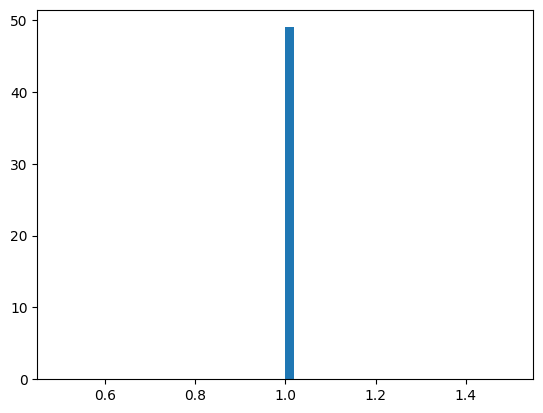

In [55]:
import matplotlib.pyplot as plt

plt.hist(total_token_counts_list, bins=50)

### LLM underthinking

This part is inspired by [Thoughts Are All Over the Place: On the Underthinking of o1-Like LLMs](https://arxiv.org/pdf/2501.18585). This paper investigated connection between the length of thought branches (fragments of solution between "Alternatively", "Wait", etc) and the solution accuracy. The found out that in many cases LLMs abandon promising solutions, cutting thought branches short before they could come to fruition - and this might contribute to failure of the whole solution.

**Your task**: create on one plot two histograms of branch lengths - one histogram for tasks with correct answer and one of tasks with incorrect answer. You can find information about answer correctness in `qwq_results["evaluation_log"]` (`"is_correct"` fields).

Since there is a different number of correct and incorrect answers in the data, we recommend normalizing the histograms so that they show frequency instead of count. This may be done by setting `density=True`. Do you see any specific patterns?

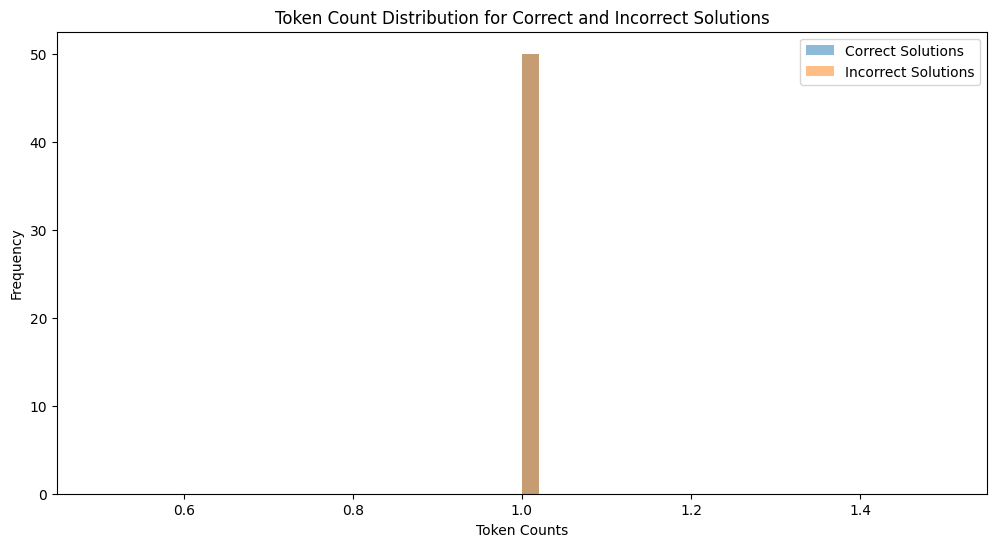

In [56]:
import matplotlib.pyplot as plt
correct_problems = [problem_id for problem_id, result in enumerate(qwq_results["evaluation_log"]) if result["is_correct"]]
incorrect_problems = [problem_id for problem_id, result in enumerate(qwq_results["evaluation_log"]) if not result["is_correct"]]

correct_token_counts = []
for problem_id in correct_problems:
    if problem_id in total_token_counts:
        correct_token_counts.extend(total_token_counts[problem_id])

incorrect_token_counts = []
for problem_id in incorrect_problems:
    if problem_id in total_token_counts:
        incorrect_token_counts.extend(total_token_counts[problem_id])

plt.figure(figsize=(12, 6))
plt.hist(correct_token_counts, bins=50, alpha=0.5, label='Correct Solutions', density=True)
plt.hist(incorrect_token_counts, bins=50, alpha=0.5, label='Incorrect Solutions', density=True)
plt.xlabel('Token Counts')
plt.ylabel('Frequency')
plt.title('Token Count Distribution for Correct and Incorrect Solutions')
plt.legend(loc='upper right')
plt.show()

In [57]:
long_thoughts = []

for problem_id, token_counts in total_token_counts.items():
    for thought_id, count in enumerate(token_counts):
        if count > 1500:
            long_thoughts.append((problem_id, thought_id, count, len(token_counts)))
            print(f"Tought with {count} tokens; total {len(token_counts)} thoughts")

long_thoughts

[]

## Task 2. Convince me with smiles

This is a continuation of the "reasoning dot by dot" section.

**Your task**: still working with **Llama-3.1-8B**, try to prompt it to output other things instead of reasoning. We personally recommend trying dots, commas, pluses, and smiles - they'll produce diverse and interesting patterns. However, feel free to try whatever you like! Don't forget to print several examples of this "reasoning". They might give you some additional insights.

Also, try running the same experiment with **Qwen/Qwen2.5-32B-Instruct**. Will you see a similar effect? Try changing not only models, but also prompts. Check how if affects the metrics.

In [59]:
dot_prompt = """You are given a question in {topic_prettified} with four answer options labeled by A, B, C, and D.
Instead of reasoning, output . Then, after #ANSWER: only output one of the letters - A, B, C, or D, the correct answer label.

QUESTION: {question}

ANSWER OPTIONS:
A: {A}
B: {B}
C: {C}
D: {D}
"""

dot_options = ["dots", "commas", "dashes", "pluses", "smiles"]

n_questions = 50

results = {}

for dot_option in dot_options:
    print(f"With {dot_option}")
    dot_evaluator = MMLUEvaluator(topic="high_school_mathematics",
                          prompt=dot_prompt.replace("", dot_option))

    dot_results = dot_evaluator.run_evaluation(model="meta-llama/Meta-Llama-3.1-8B-Instruct",
                         n_questions=n_questions)

    results[dot_option] = dot_results

    print(f'\nAccuracy: {dot_results["accuracy"]}')
    print(dot_results['evaluation_log'][0])


With dots


100%|██████████| 50/50 [00:00<00:00, 9642.52it/s]


Error evaluating question: 'dotstdotsodotspdotsidotscdots_dotspdotsrdotsedotstdotstdotsidotsfdotsidotsedotsddots'
Error evaluating question: 'dotstdotsodotspdotsidotscdots_dotspdotsrdotsedotstdotstdotsidotsfdotsidotsedotsddots'
Error evaluating question: 'dotstdotsodotspdotsidotscdots_dotspdotsrdotsedotstdotstdotsidotsfdotsidotsedotsddots'
Error evaluating question: 'dotstdotsodotspdotsidotscdots_dotspdotsrdotsedotstdotstdotsidotsfdotsidotsedotsddots'
Error evaluating question: 'dotstdotsodotspdotsidotscdots_dotspdotsrdotsedotstdotstdotsidotsfdotsidotsedotsddots'
Error evaluating question: 'dotstdotsodotspdotsidotscdots_dotspdotsrdotsedotstdotstdotsidotsfdotsidotsedotsddots'
Error evaluating question: 'dotstdotsodotspdotsidotscdots_dotspdotsrdotsedotstdotstdotsidotsfdotsidotsedotsddots'
Error evaluating question: 'dotstdotsodotspdotsidotscdots_dotspdotsrdotsedotstdotstdotsidotsfdotsidotsedotsddots'
Error evaluating question: 'dotstdotsodotspdotsidotscdots_dotspdotsrdotsedotstdotstdotsi

100%|██████████| 50/50 [00:00<00:00, 11073.19it/s]


Error evaluating question: 'commastcommasocommaspcommasicommasccommas_commaspcommasrcommasecommastcommastcommasicommasfcommasicommasecommasdcommas'
Error evaluating question: 'commastcommasocommaspcommasicommasccommas_commaspcommasrcommasecommastcommastcommasicommasfcommasicommasecommasdcommas'
Error evaluating question: 'commastcommasocommaspcommasicommasccommas_commaspcommasrcommasecommastcommastcommasicommasfcommasicommasecommasdcommas'
Error evaluating question: 'commastcommasocommaspcommasicommasccommas_commaspcommasrcommasecommastcommastcommasicommasfcommasicommasecommasdcommas'
Error evaluating question: 'commastcommasocommaspcommasicommasccommas_commaspcommasrcommasecommastcommastcommasicommasfcommasicommasecommasdcommas'
Error evaluating question: 'commastcommasocommaspcommasicommasccommas_commaspcommasrcommasecommastcommastcommasicommasfcommasicommasecommasdcommas'
Error evaluating question: 'commastcommasocommaspcommasicommasccommas_commaspcommasrcommasecommastcommastcommasi

100%|██████████| 50/50 [00:00<00:00, 10907.90it/s]


Error evaluating question: 'dashestdashesodashespdashesidashescdashes_dashespdashesrdashesedashestdashestdashesidashesfdashesidashesedashesddashes'
Error evaluating question: 'dashestdashesodashespdashesidashescdashes_dashespdashesrdashesedashestdashestdashesidashesfdashesidashesedashesddashes'
Error evaluating question: 'dashestdashesodashespdashesidashescdashes_dashespdashesrdashesedashestdashestdashesidashesfdashesidashesedashesddashes'
Error evaluating question: 'dashestdashesodashespdashesidashescdashes_dashespdashesrdashesedashestdashestdashesidashesfdashesidashesedashesddashes'
Error evaluating question: 'dashestdashesodashespdashesidashescdashes_dashespdashesrdashesedashestdashestdashesidashesfdashesidashesedashesddashes'
Error evaluating question: 'dashestdashesodashespdashesidashescdashes_dashespdashesrdashesedashestdashestdashesidashesfdashesidashesedashesddashes'
Error evaluating question: 'dashestdashesodashespdashesidashescdashes_dashespdashesrdashesedashestdashestdashesi

100%|██████████| 50/50 [00:00<00:00, 11787.05it/s]


Error evaluating question: 'plusestplusesoplusespplusesiplusescpluses_plusespplusesrpluseseplusestplusestplusesiplusesfplusesipluseseplusesdpluses'
Error evaluating question: 'plusestplusesoplusespplusesiplusescpluses_plusespplusesrpluseseplusestplusestplusesiplusesfplusesipluseseplusesdpluses'
Error evaluating question: 'plusestplusesoplusespplusesiplusescpluses_plusespplusesrpluseseplusestplusestplusesiplusesfplusesipluseseplusesdpluses'
Error evaluating question: 'plusestplusesoplusespplusesiplusescpluses_plusespplusesrpluseseplusestplusestplusesiplusesfplusesipluseseplusesdpluses'
Error evaluating question: 'plusestplusesoplusespplusesiplusescpluses_plusespplusesrpluseseplusestplusestplusesiplusesfplusesipluseseplusesdpluses'
Error evaluating question: 'plusestplusesoplusespplusesiplusescpluses_plusespplusesrpluseseplusestplusestplusesiplusesfplusesipluseseplusesdpluses'
Error evaluating question: 'plusestplusesoplusespplusesiplusescpluses_plusespplusesrpluseseplusestplusestplusesi

100%|██████████| 50/50 [00:00<00:00, 12652.50it/s]

Error evaluating question: 'smilestsmilesosmilespsmilesismilescsmiles_smilespsmilesrsmilesesmilestsmilestsmilesismilesfsmilesismilesesmilesdsmiles'
Error evaluating question: 'smilestsmilesosmilespsmilesismilescsmiles_smilespsmilesrsmilesesmilestsmilestsmilesismilesfsmilesismilesesmilesdsmiles'
Error evaluating question: 'smilestsmilesosmilespsmilesismilescsmiles_smilespsmilesrsmilesesmilestsmilestsmilesismilesfsmilesismilesesmilesdsmiles'
Error evaluating question: 'smilestsmilesosmilespsmilesismilescsmiles_smilespsmilesrsmilesesmilestsmilestsmilesismilesfsmilesismilesesmilesdsmiles'
Error evaluating question: 'smilestsmilesosmilespsmilesismilescsmiles_smilespsmilesrsmilesesmilestsmilestsmilesismilesfsmilesismilesesmilesdsmiles'
Error evaluating question: 'smilestsmilesosmilespsmilesismilescsmiles_smilespsmilesrsmilesesmilestsmilestsmilesismilesfsmilesismilesesmilesdsmiles'
Error evaluating question: 'smilestsmilesosmilespsmilesismilescsmiles_smilespsmilesrsmilesesmilestsmilestsmilesi

In [60]:
dot_prompt = """You are given a question in {topic_prettified} with four answer options labeled by A, B, C, and D.
Instead of reasoning, output . Then, after #ANSWER: only output one of the letters - A, B, C, or D, the correct answer label.

QUESTION: {question}

ANSWER OPTIONS:
A: {A}
B: {B}
C: {C}
D: {D}
"""

dot_options = ["dots", "commas", "dashes", "pluses", "smiles"]

n_questions = 50

results = {}

for dot_option in dot_options:
    print(f"With {dot_option}")
    dot_evaluator = MMLUEvaluator(topic="high_school_mathematics",
                          prompt=dot_prompt.replace("", dot_option))

    dot_results = dot_evaluator.run_evaluation(
        client=client,
        model="Qwen/Qwen2.5-32B-Instruct",
        n_questions=n_questions)

    results[dot_option] = dot_results

    print(f'\nAccuracy: {dot_results["accuracy"]}')
    print(dot_results['evaluation_log'][0])

With dots


100%|██████████| 50/50 [00:00<00:00, 10849.21it/s]


Error evaluating question: 'dotstdotsodotspdotsidotscdots_dotspdotsrdotsedotstdotstdotsidotsfdotsidotsedotsddots'
Error evaluating question: 'dotstdotsodotspdotsidotscdots_dotspdotsrdotsedotstdotstdotsidotsfdotsidotsedotsddots'
Error evaluating question: 'dotstdotsodotspdotsidotscdots_dotspdotsrdotsedotstdotstdotsidotsfdotsidotsedotsddots'
Error evaluating question: 'dotstdotsodotspdotsidotscdots_dotspdotsrdotsedotstdotstdotsidotsfdotsidotsedotsddots'
Error evaluating question: 'dotstdotsodotspdotsidotscdots_dotspdotsrdotsedotstdotstdotsidotsfdotsidotsedotsddots'
Error evaluating question: 'dotstdotsodotspdotsidotscdots_dotspdotsrdotsedotstdotstdotsidotsfdotsidotsedotsddots'
Error evaluating question: 'dotstdotsodotspdotsidotscdots_dotspdotsrdotsedotstdotstdotsidotsfdotsidotsedotsddots'
Error evaluating question: 'dotstdotsodotspdotsidotscdots_dotspdotsrdotsedotstdotstdotsidotsfdotsidotsedotsddots'
Error evaluating question: 'dotstdotsodotspdotsidotscdots_dotspdotsrdotsedotstdotstdotsi

100%|██████████| 50/50 [00:00<00:00, 7779.33it/s]


Error evaluating question: 'commastcommasocommaspcommasicommasccommas_commaspcommasrcommasecommastcommastcommasicommasfcommasicommasecommasdcommas'
Error evaluating question: 'commastcommasocommaspcommasicommasccommas_commaspcommasrcommasecommastcommastcommasicommasfcommasicommasecommasdcommas'
Error evaluating question: 'commastcommasocommaspcommasicommasccommas_commaspcommasrcommasecommastcommastcommasicommasfcommasicommasecommasdcommas'
Error evaluating question: 'commastcommasocommaspcommasicommasccommas_commaspcommasrcommasecommastcommastcommasicommasfcommasicommasecommasdcommas'
Error evaluating question: 'commastcommasocommaspcommasicommasccommas_commaspcommasrcommasecommastcommastcommasicommasfcommasicommasecommasdcommas'
Error evaluating question: 'commastcommasocommaspcommasicommasccommas_commaspcommasrcommasecommastcommastcommasicommasfcommasicommasecommasdcommas'
Error evaluating question: 'commastcommasocommaspcommasicommasccommas_commaspcommasrcommasecommastcommastcommasi

100%|██████████| 50/50 [00:00<00:00, 11224.92it/s]


Error evaluating question: 'dashestdashesodashespdashesidashescdashes_dashespdashesrdashesedashestdashestdashesidashesfdashesidashesedashesddashes'
Error evaluating question: 'dashestdashesodashespdashesidashescdashes_dashespdashesrdashesedashestdashestdashesidashesfdashesidashesedashesddashes'
Error evaluating question: 'dashestdashesodashespdashesidashescdashes_dashespdashesrdashesedashestdashestdashesidashesfdashesidashesedashesddashes'
Error evaluating question: 'dashestdashesodashespdashesidashescdashes_dashespdashesrdashesedashestdashestdashesidashesfdashesidashesedashesddashes'
Error evaluating question: 'dashestdashesodashespdashesidashescdashes_dashespdashesrdashesedashestdashestdashesidashesfdashesidashesedashesddashes'
Error evaluating question: 'dashestdashesodashespdashesidashescdashes_dashespdashesrdashesedashestdashestdashesidashesfdashesidashesedashesddashes'
Error evaluating question: 'dashestdashesodashespdashesidashescdashes_dashespdashesrdashesedashestdashestdashesi

100%|██████████| 50/50 [00:00<00:00, 19756.50it/s]


Error evaluating question: 'plusestplusesoplusespplusesiplusescpluses_plusespplusesrpluseseplusestplusestplusesiplusesfplusesipluseseplusesdpluses'
Error evaluating question: 'plusestplusesoplusespplusesiplusescpluses_plusespplusesrpluseseplusestplusestplusesiplusesfplusesipluseseplusesdpluses'
Error evaluating question: 'plusestplusesoplusespplusesiplusescpluses_plusespplusesrpluseseplusestplusestplusesiplusesfplusesipluseseplusesdpluses'
Error evaluating question: 'plusestplusesoplusespplusesiplusescpluses_plusespplusesrpluseseplusestplusestplusesiplusesfplusesipluseseplusesdpluses'
Error evaluating question: 'plusestplusesoplusespplusesiplusescpluses_plusespplusesrpluseseplusestplusestplusesiplusesfplusesipluseseplusesdpluses'
Error evaluating question: 'plusestplusesoplusespplusesiplusescpluses_plusespplusesrpluseseplusestplusestplusesiplusesfplusesipluseseplusesdpluses'
Error evaluating question: 'plusestplusesoplusespplusesiplusescpluses_plusespplusesrpluseseplusestplusestplusesi

100%|██████████| 50/50 [00:00<00:00, 11329.22it/s]

Error evaluating question: 'smilestsmilesosmilespsmilesismilescsmiles_smilespsmilesrsmilesesmilestsmilestsmilesismilesfsmilesismilesesmilesdsmiles'
Error evaluating question: 'smilestsmilesosmilespsmilesismilescsmiles_smilespsmilesrsmilesesmilestsmilestsmilesismilesfsmilesismilesesmilesdsmiles'
Error evaluating question: 'smilestsmilesosmilespsmilesismilescsmiles_smilespsmilesrsmilesesmilestsmilestsmilesismilesfsmilesismilesesmilesdsmiles'
Error evaluating question: 'smilestsmilesosmilespsmilesismilescsmiles_smilespsmilesrsmilesesmilestsmilestsmilesismilesfsmilesismilesesmilesdsmiles'
Error evaluating question: 'smilestsmilesosmilespsmilesismilescsmiles_smilespsmilesrsmilesesmilestsmilestsmilesismilesfsmilesismilesesmilesdsmiles'
Error evaluating question: 'smilestsmilesosmilespsmilesismilescsmiles_smilespsmilesrsmilesesmilestsmilestsmilesismilesfsmilesismilesesmilesdsmiles'
Error evaluating question: 'smilestsmilesosmilespsmilesismilescsmiles_smilespsmilesrsmilesesmilestsmilestsmilesi